In [1]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ranitadey21","key":"955de21b3dc88615ac3ff170962b367b"}'}

In [2]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download and unzip dataset
!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip face-mask-dataset.zip -d face_mask_data

Streaming output truncated to the last 5000 lines.
  inflating: face_mask_data/data/with_mask/with_mask_3297.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3298.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3299.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_33.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_330.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3300.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3301.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3302.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3303.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3304.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3305.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3306.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3307.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_3308.jpg  
  inflating: face_mask_data/data/with_mask/with_mask_330

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import os
import shutil
import random

In [12]:
# Define original dataset path
base_dir = "face_mask_data/data"
new_base_dir = "dataset_split"

# Create new directories
for folder in ["train", "test"]:
    for category in ["with_mask", "without_mask"]:
        os.makedirs(os.path.join(new_base_dir, folder, category), exist_ok=True)

# Split dataset (80% Train, 20% Test)
for category in ["with_mask", "without_mask"]:
    src_dir = os.path.join(base_dir, category)
    images = os.listdir(src_dir)
    random.shuffle(images)

    split_index = int(0.8 * len(images))  # 80% Train, 20% Test
    train_images = images[:split_index]
    test_images = images[split_index:]

    for img in train_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(new_base_dir, "train", category))
    for img in test_images:
        shutil.copy(os.path.join(src_dir, img), os.path.join(new_base_dir, "test", category))

print("Dataset split completed successfully!")


Dataset split completed successfully!


In [14]:
train_dir = "dataset_split/train"
test_dir = "dataset_split/test"
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 4834 images belonging to 2 classes.
Found 1208 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


In [18]:
# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)  # ✅ Correctly assign output layer

# Define Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 535ms/step - accuracy: 0.9844 - loss: 0.0407 - val_accuracy: 0.9810 - val_loss: 0.0709
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 533ms/step - accuracy: 0.9808 - loss: 0.0560 - val_accuracy: 0.9760 - val_loss: 0.0668
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 534ms/step - accuracy: 0.9810 - loss: 0.0507 - val_accuracy: 0.9859 - val_loss: 0.0444
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 534ms/step - accuracy: 0.9875 - loss: 0.0368 - val_accuracy: 0.9743 - val_loss: 0.0715
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 531ms/step - accuracy: 0.9850 - loss: 0.0469 - val_accuracy: 0.9818 - val_loss: 0.0530
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 528ms/step - accuracy: 0.9881 - loss: 0.0296 - val_accuracy: 0.9793 - val_loss: 0.0744
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 81s 531ms/step - accuracy: 0.9853 - loss: 0.0405 - val_accuracy: 0.9818 - val_loss: 0.0638
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 80s 528ms/step - accuracy: 0.9855 - loss: 0

In [22]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9806 - loss: 0.0433
Test Accuracy: 0.9801


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np

# Get True Labels and Predictions
y_true = []
y_pred = []

for images, labels in test_generator:
    preds = model.predict(images)
    preds = np.round(preds)  # Convert probabilities to binary labels (0 or 1)

    y_true.extend(labels)
    y_pred.extend(preds.flatten())

    if len(y_true) >= test_generator.samples:  # Stop after full test set
        break

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━

In [24]:
# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision
precision = precision_score(y_true, y_pred)

# Recall
recall = recall_score(y_true, y_pred)

# F1-score
f1 = f1_score(y_true, y_pred)

# ROC-AUC Score
roc_auc = roc_auc_score(y_true, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print Results
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ ROC-AUC Score: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

✅ Accuracy: 0.9801
✅ Precision: 0.9973
✅ Recall: 0.9634
✅ F1 Score: 0.9801
✅ ROC-AUC Score: 0.9804

Confusion Matrix:
[[743   2]
 [ 28 738]]


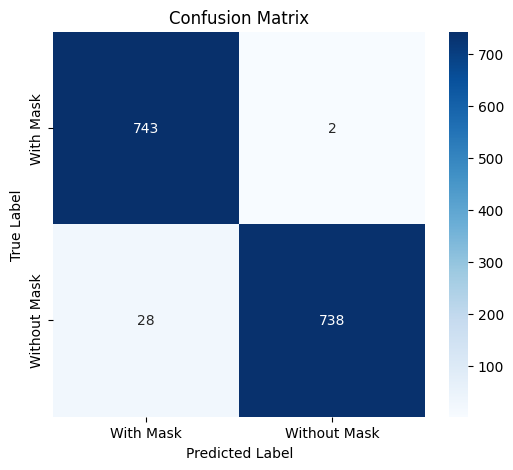

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["With Mask", "Without Mask"], yticklabels=["With Mask", "Without Mask"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

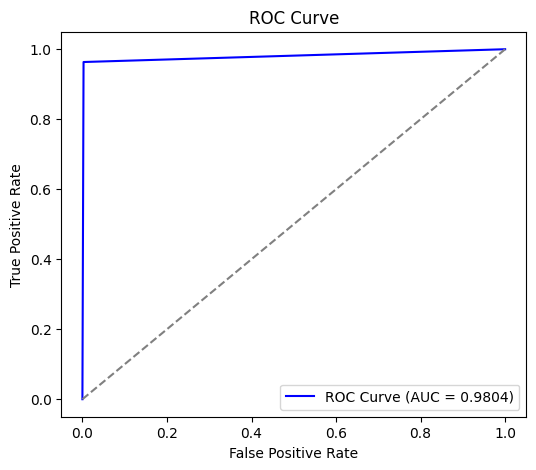

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', label="ROC Curve (AUC = {:.4f})".format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [28]:
# Save the trained model
model.save("face_mask_model.h5")

# Download the model to your local system
from google.colab import files
files.download("face_mask_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
from google.colab import files
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Load trained model once
model = load_model("face_mask_model.h5")

def predict_mask():
    """
    A function to predict if a person is wearing a mask or not. It is created so we don't have to write codes for each test case.
    """
    # Upload an image
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Open and preprocess the image
        img = Image.open(filename).convert("RGB")
        img = img.resize((224, 224))  # Resize to MobileNetV2 input size
        img = np.array(img) / 255.0  # Normalize
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        # Make prediction
        prediction = model.predict(img)
        label = "Mask" if prediction < 0.5 else "No Mask"

        # Show result
        print(f"✅ Prediction: {label}")
        img = Image.open(filename)
        img.show()


In [33]:
# Call function to test (No mask image is given to test)
predict_mask()

Saving nomask.jpg to nomask.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
✅ Prediction: No Mask


In [34]:
# Call function to test (Masked image is given for test)
predict_mask()

Saving mask.jpg to mask.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ Prediction: Mask
